# Autoencoder

A good way to detect drift in time series data is to use an autoencoder. An autoencoder is a machine learning model which tries to reproduce its inputs. It will do this by first reducing the inputs to a smaller representation trough an encoder. Afterwards a decoder will reconstruct the input from this smaller representation. This means that when the autoencoder is trained on a certain dataset, it can reproduce those inputs well, but when data data distribution has drifted, it will not be able to reproduce it's inputs anymore. This way we can detect when there is drift. 

<img src="images/autoencoder.png"   />

In [1]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from utils.data_utils_ae import split_in_sequences, create_dataloader, split_train_test_dataset

## Model definition
You can create your autoencoder model like any other pytorch model. The only difference is that the dimension size first reduces and than grows again to its original size. A lot of people however, also split the autoencoder into the encoder and the decoder part. So first we define our encoder.

In [2]:
class Encoder(nn.Module):
    def __init__(self, seq_len):
        
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        
        self.layer1 = nn.Linear(self.seq_len,256, bias=True)
        nn.init.kaiming_normal_(self.layer1.weight, mode="fan_in", nonlinearity="relu")
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(256,128, bias=True)
        nn.init.kaiming_normal_(self.layer2.weight, mode="fan_in", nonlinearity="relu")
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(128,64, bias=True)
        nn.init.kaiming_normal_(self.layer3.weight, mode="fan_in", nonlinearity="relu")
        self.act3 = nn.ReLU()
        self.layer4 = nn.Linear(64,32, bias=True)
        nn.init.kaiming_normal_(self.layer4.weight, mode="fan_in", nonlinearity="relu")
        self.act4 = nn.ReLU()


    def forward(self, input_tensor):
        x = self.act1(self.layer1(input_tensor))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        return x

Then we define our decoder. Maker sure the sizes of the hidden layers are the same as the sizes of the encoder reversed. The first layer of the decoder is the embedding dimension, it is a linear layer that has the same input and output size, namely the embedding dimension size.

In [3]:
class Decoder(nn.Module):
    def __init__(self, seq_len):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.layer0 = nn.Linear(32,32, bias=True)
        nn.init.kaiming_normal_(self.layer0.weight, mode="fan_in", nonlinearity="relu")
        self.act0 = nn.ReLU()
        self.layer1 = nn.Linear(32,64, bias=True)
        nn.init.kaiming_normal_(self.layer1.weight, mode="fan_in", nonlinearity="relu")
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(64,128, bias=True)
        nn.init.kaiming_normal_(self.layer2.weight, mode="fan_in", nonlinearity="relu")
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(128,256, bias=True)
        nn.init.kaiming_normal_(self.layer3.weight, mode="fan_in", nonlinearity="relu")
        self.act3 = nn.ReLU()
        self.layer4 = nn.Linear(256,self.seq_len, bias=True)
        nn.init.kaiming_normal_(self.layer4.weight, mode="fan_in", nonlinearity="relu")
        self.act4 = nn.ReLU()

    def forward(self, input_tensor):
        x = self.act0(self.layer0(input_tensor))
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        return x

Lastly we bring the two together in one class, the autoencoder. Here we also define the loss function. Choose a good autoencoder loss function. As help you can look at this [page](https://www.geeksforgeeks.org/loss-functions-in-deep-learning/).

In [4]:
    
class EncoderDecoder(nn.Module):
    def __init__(self, train_params, seq_len):

        super(EncoderDecoder, self).__init__()

        self.n_epochs = train_params["epochs"]
        self.batch_size = train_params["batch_size"]

        self.seq_len = seq_len
        self.criterion = nn.MSELoss(reduction='mean')

        self.encoder = Encoder(seq_len)
        self.decoder = Decoder(seq_len)


    def forward(self, input_tensor):
        
        x = self.encoder(input_tensor)
        x = self.decoder(x)
    
        return x

Next we define our train function. This is a standard pytorch trainingloop. The only difference is that our inputs are also our true labels in the loss function and other evaluation metric calculation. Choose a good evaluation metric to use next to your loss function to evaluate your predictions on. Again, [here](https://www.geeksforgeeks.org/regression-metrics/) is a page that can help you.

In [5]:
def train_model(model, train_dataset, val_dataset, train_params):
    best_loss = np.inf
    best_model = None
    history = dict(train_loss=[], val_loss=[], train_mse=[], val_mse=[])

    optimizer = torch.optim.Adam(model.parameters(), lr=train_params["learning_rate"], weight_decay=1e-8)
    criterion = model.criterion
    # train the model. Run the model on the inputs, calculate the losses, do backpropagation
    for epoch in range(1, train_params["epochs"]):
        model = model.train()
        train_losses = []
        train_mses = []
    
        for (seq_true,) in train_dataset:
            optimizer.zero_grad()
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            loss.backward()
            mse = mean_absolute_error(seq_true.tolist()[0], seq_pred.tolist()[0])

            optimizer.step()
            train_losses.append(loss.item())
            train_mses.append(mse)

        model = model.eval()
        val_losses = []
        val_mses = []
        # run the model and loss on the validation function
        with torch.no_grad():
            for (seq_true,) in val_dataset:
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)     
                mse = mean_absolute_error(seq_true.tolist()[0], seq_pred.tolist()[0])

                val_losses.append(loss.item())
                val_mses.append(mse)
                
        # get the losses and mse from the epoch
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_mse = np.mean(train_mses)
        val_mse = np.mean(val_mses)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)

        # decide if this version of the model is the best
        loss = float(val_loss)
        if loss < best_loss:
            best_loss = val_loss
            best_model = model

        text = f'Epoch = {epoch}, train loss = {train_loss}, val loss = {val_loss}'
        print(text)

    return history, best_model

Lastly, before we start with our dataset, we will also define a predict function which will input our data and return the predictions of the model.

In [6]:
def predict(model, dataset):
    predictions, true, losses, eval_metrics = [], [], [], []
    criterion = model.criterion
    model = model.eval()
    with torch.no_grad():
        for (seq_true,) in dataset:
            # seq_true = torch.Tensor(seq_true)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
                
            seq_true_acc = np.array([item for row in seq_true.tolist() for item in row])
            seq_pred_acc = np.array([item for row in seq_pred.tolist() for item in row])
            eval_metric = np.mean(np.abs(seq_true_acc - seq_pred_acc))

            # flatten all data to be able to use as an array
            predictions.append(seq_pred.numpy().flatten())
            true.append(seq_true.numpy().flatten())
            losses.append(loss.item())
            eval_metrics.append(eval_metric)

    return predictions, losses, eval_metrics, true

## Data 

Now we can train our autoencoder on a dataset. The dataset we use consists of "noise" data which can have different variances and different means. We are going to train our machine learning model on data with 1 specific mean. Then we will evaluate our machine learning model on a time series which contains data with all the different means and variances. Before we can do this, however, we need to load and prepare our dataset. using the functions in the Data_utils_ae.py file, create a "create_data_train" function which has the length of the input samples and the batch size as input and outputs a train and validation dataloader.

In [19]:
def create_data_train(seq_len, batch_size):
    dataframe_train = pd.read_csv("dataset/training_data_autoencoder.csv", delimiter=";") 

    dataframe_train = split_in_sequences(dataframe_train, seq_len)
    train, val, test = split_train_test_dataset(dataframe_train)

    dataloader_train = create_dataloader(train, batch_size)
    dataloader_val = create_dataloader(val, batch_size)
    dataloader_test = create_dataloader(test, batch_size)
    return dataloader_train, dataloader_val, dataloader_test


## Train the model
Next, choose your hyperparameters for the autoencoder.

In [20]:
def create_parameters():
    learning_rate = 0.001
    epochs = 5000
    batch_size = 8
    seq_len = 50

    train_params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size
    }
    return seq_len, train_params

Now you can use the created functions to train an autoencoder and run predictions on the test set. Play around with your model size and hyperparameters untill you get a model that can reproduce its input data well. You can check this using the loss graph and encoder graph functions defined below.

In [21]:
def loss_graph(history):
    train_loss = history['train_loss']
    print("train loss: " + str(train_loss))
    val_loss = history['val_loss']
    train_mse = history['train_mse']
    val_mse = history['val_mse']

    fig, axs = plt.subplots(2,1)

    axs[0].plot(train_loss, label='train')
    axs[0].plot(val_loss, label='val')
    axs[1].plot(train_mse, label='train')
    axs[1].plot(val_mse, label='val')

    axs[0].set_xlabel("epochs")
    axs[1].set_xlabel("epochs")

    axs[0].set_ylabel("Loss")
    axs[1].set_ylabel("MSE")

    axs[0].set_title("Train vs. validation loss")
    axs[1].set_title("Train vs. validation MSE")

    axs[0].legend()
    fig.set_size_inches(10, 10, forward=True)
    fig.tight_layout()
    fig.show()

In [22]:
def autoencoder_graph( predictions,inputs, acc):
    predictions = np.concatenate(predictions).tolist()
    inputs = np.concatenate(inputs).tolist()
    fig, axs = plt.subplots(2,1)

    axs[0].plot(inputs, label='inputs')
    axs[0].plot(predictions, label='predictions')
    axs[1].plot(acc)

    axs[0].set_xlabel("number of samples")
    axs[1].set_xlabel("number of samples")

    axs[0].set_ylabel("value")
    axs[1].set_ylabel("Evaluation metric")

    axs[0].set_title("Test predictions vs inputs curve")
    axs[1].set_title("Evaluation metric")

    axs[0].legend()
    fig.set_size_inches(16.5, 16.5, forward=True)
    fig.tight_layout()
    fig.show()

In [23]:
seq_len, train_params = create_parameters()
dataloader_train, dataloader_val, dataloader_test = create_data_train(seq_len, train_params["batch_size"])
autoencoder = EncoderDecoder(train_params, seq_len)
history, best_model = train_model(autoencoder, dataloader_train, dataloader_val, train_params)
predictions, losses, acccuracies, true_values = predict(autoencoder, dataloader_test)


Epoch = 1, train loss = 0.10498271907369296, val loss = 0.08508719876408577
Epoch = 2, train loss = 0.08506584937373797, val loss = 0.08452889323234558
Epoch = 3, train loss = 0.08476834048827489, val loss = 0.08439423702657223
Epoch = 4, train loss = 0.08470883965492249, val loss = 0.08435153774917126
Epoch = 5, train loss = 0.08467037677764892, val loss = 0.08435557223856449
Epoch = 6, train loss = 0.08464967658122381, val loss = 0.08433648943901062
Epoch = 7, train loss = 0.0846258394420147, val loss = 0.08432934619486332
Epoch = 8, train loss = 0.08458450709780058, val loss = 0.08431771770119667
Epoch = 9, train loss = 0.0845701441168785, val loss = 0.08430127613246441
Epoch = 10, train loss = 0.08455750048160553, val loss = 0.08432545699179173
Epoch = 11, train loss = 0.08454598262906074, val loss = 0.08433070220053196
Epoch = 12, train loss = 0.0845482292274634, val loss = 0.08431831561028957
Epoch = 13, train loss = 0.08453475733598073, val loss = 0.08433981984853745
Epoch = 14,

train loss: [np.float64(0.10498271907369296), np.float64(0.08506584937373797), np.float64(0.08476834048827489), np.float64(0.08470883965492249), np.float64(0.08467037677764892), np.float64(0.08464967658122381), np.float64(0.0846258394420147), np.float64(0.08458450709780058), np.float64(0.0845701441168785), np.float64(0.08455750048160553), np.float64(0.08454598262906074), np.float64(0.0845482292274634), np.float64(0.08453475733598073), np.float64(0.08453151534001033), np.float64(0.08453326150774956), np.float64(0.08452767928441365), np.float64(0.08453351482748986), np.float64(0.08453736404577891), np.float64(0.08453596656521162), np.float64(0.08451609934369723), np.float64(0.08449597458044687), np.float64(0.08449313168724377), np.float64(0.08449003249406814), np.float64(0.08448520998160045), np.float64(0.08448910837372144), np.float64(0.08447647045056025), np.float64(0.08447062174479167), np.float64(0.08446635926763217), np.float64(0.08445929735898972), np.float64(0.08447665174802145), 

C:\Users\laral\AppData\Local\Temp\ipykernel_38476\3451447401.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


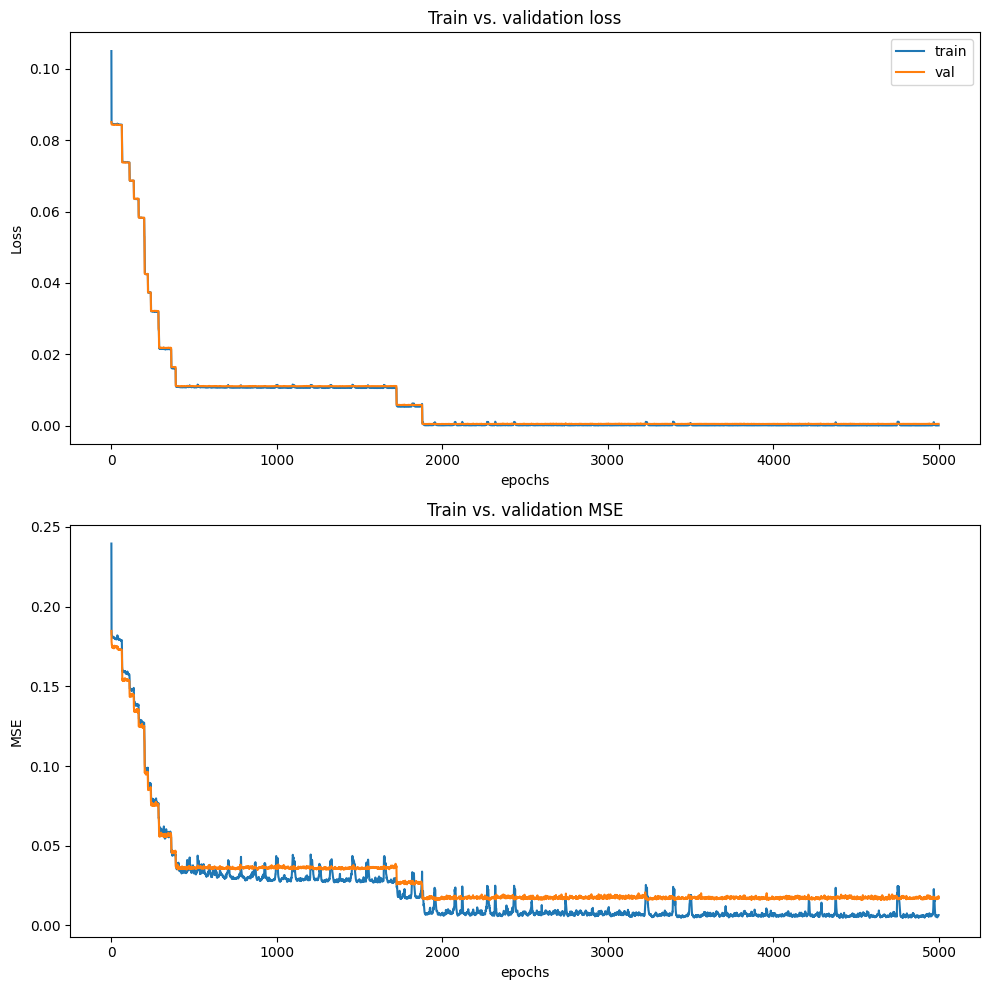

In [24]:
loss_graph(history)

C:\Users\laral\AppData\Local\Temp\ipykernel_38476\1418696462.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


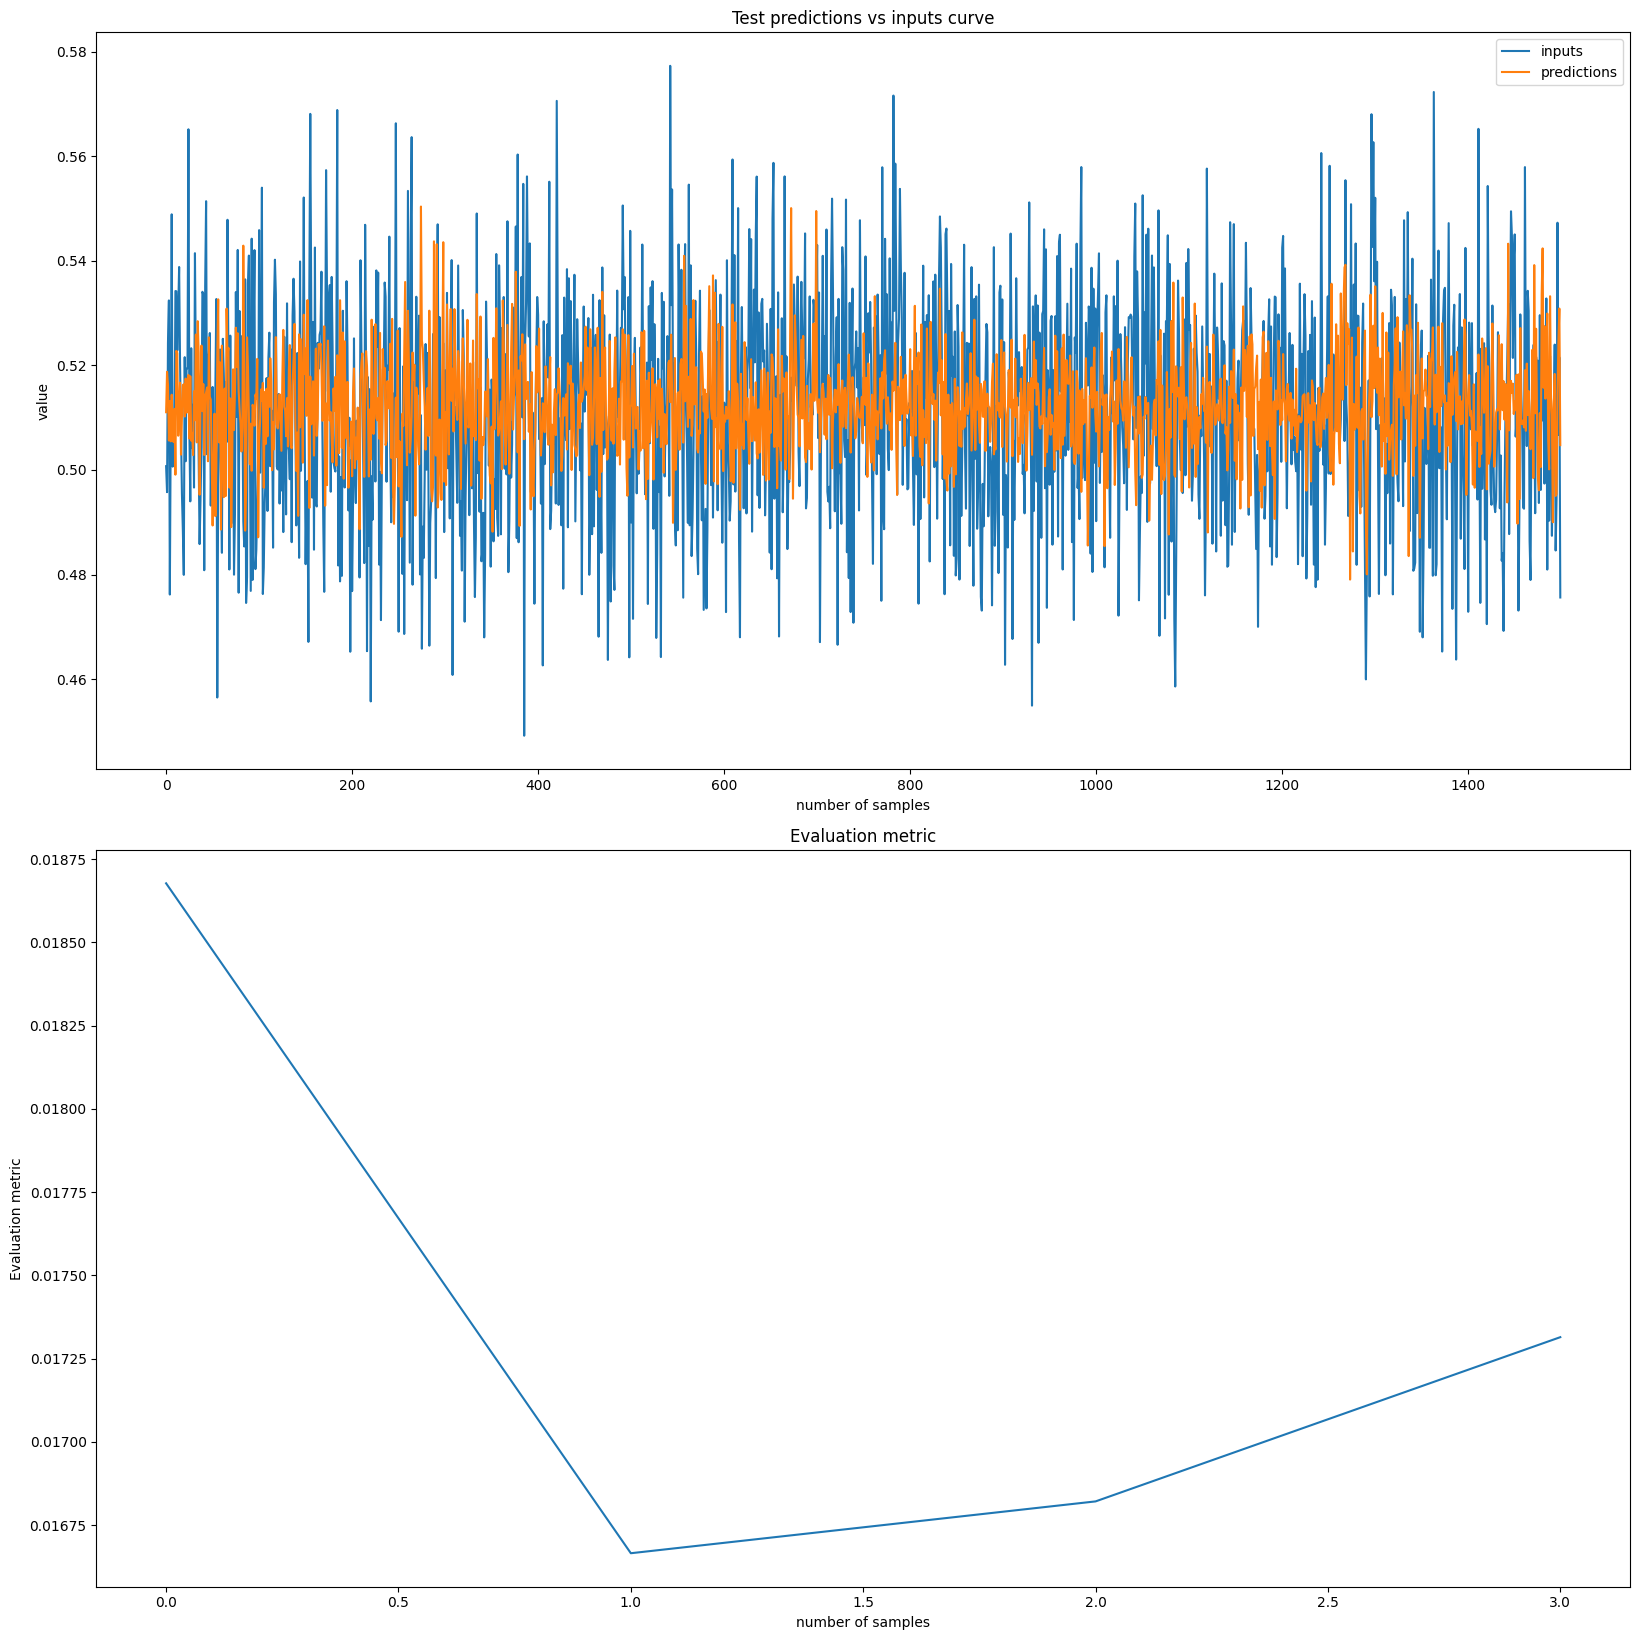

In [25]:
autoencoder_graph(predictions, true_values, acccuracies)

## The model on a new dataset
Create a "create_data_drift" function which does the same for the test dataset as it did for the training dataset, without splitting it into a train, val and test set.
Then run the model on this new dataset and look at the results.

In [26]:
def create_data_drift(seq_len, batch_size):
    dataframe_drift = pd.read_csv("dataset/new_data_autoencoder.csv", delimiter=";") 
    # dataframe_train["date"] = pd.to_datetime(dataframe_train['date'], format='%Y-%m-%d')
    # dataframe_train = normalize_datset(dataframe_train)
    dataframe_drift = split_in_sequences(dataframe_drift, seq_len)

    dataloader_drift = create_dataloader(dataframe_drift, batch_size)
    return dataloader_drift

C:\Users\laral\AppData\Local\Temp\ipykernel_38476\1418696462.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


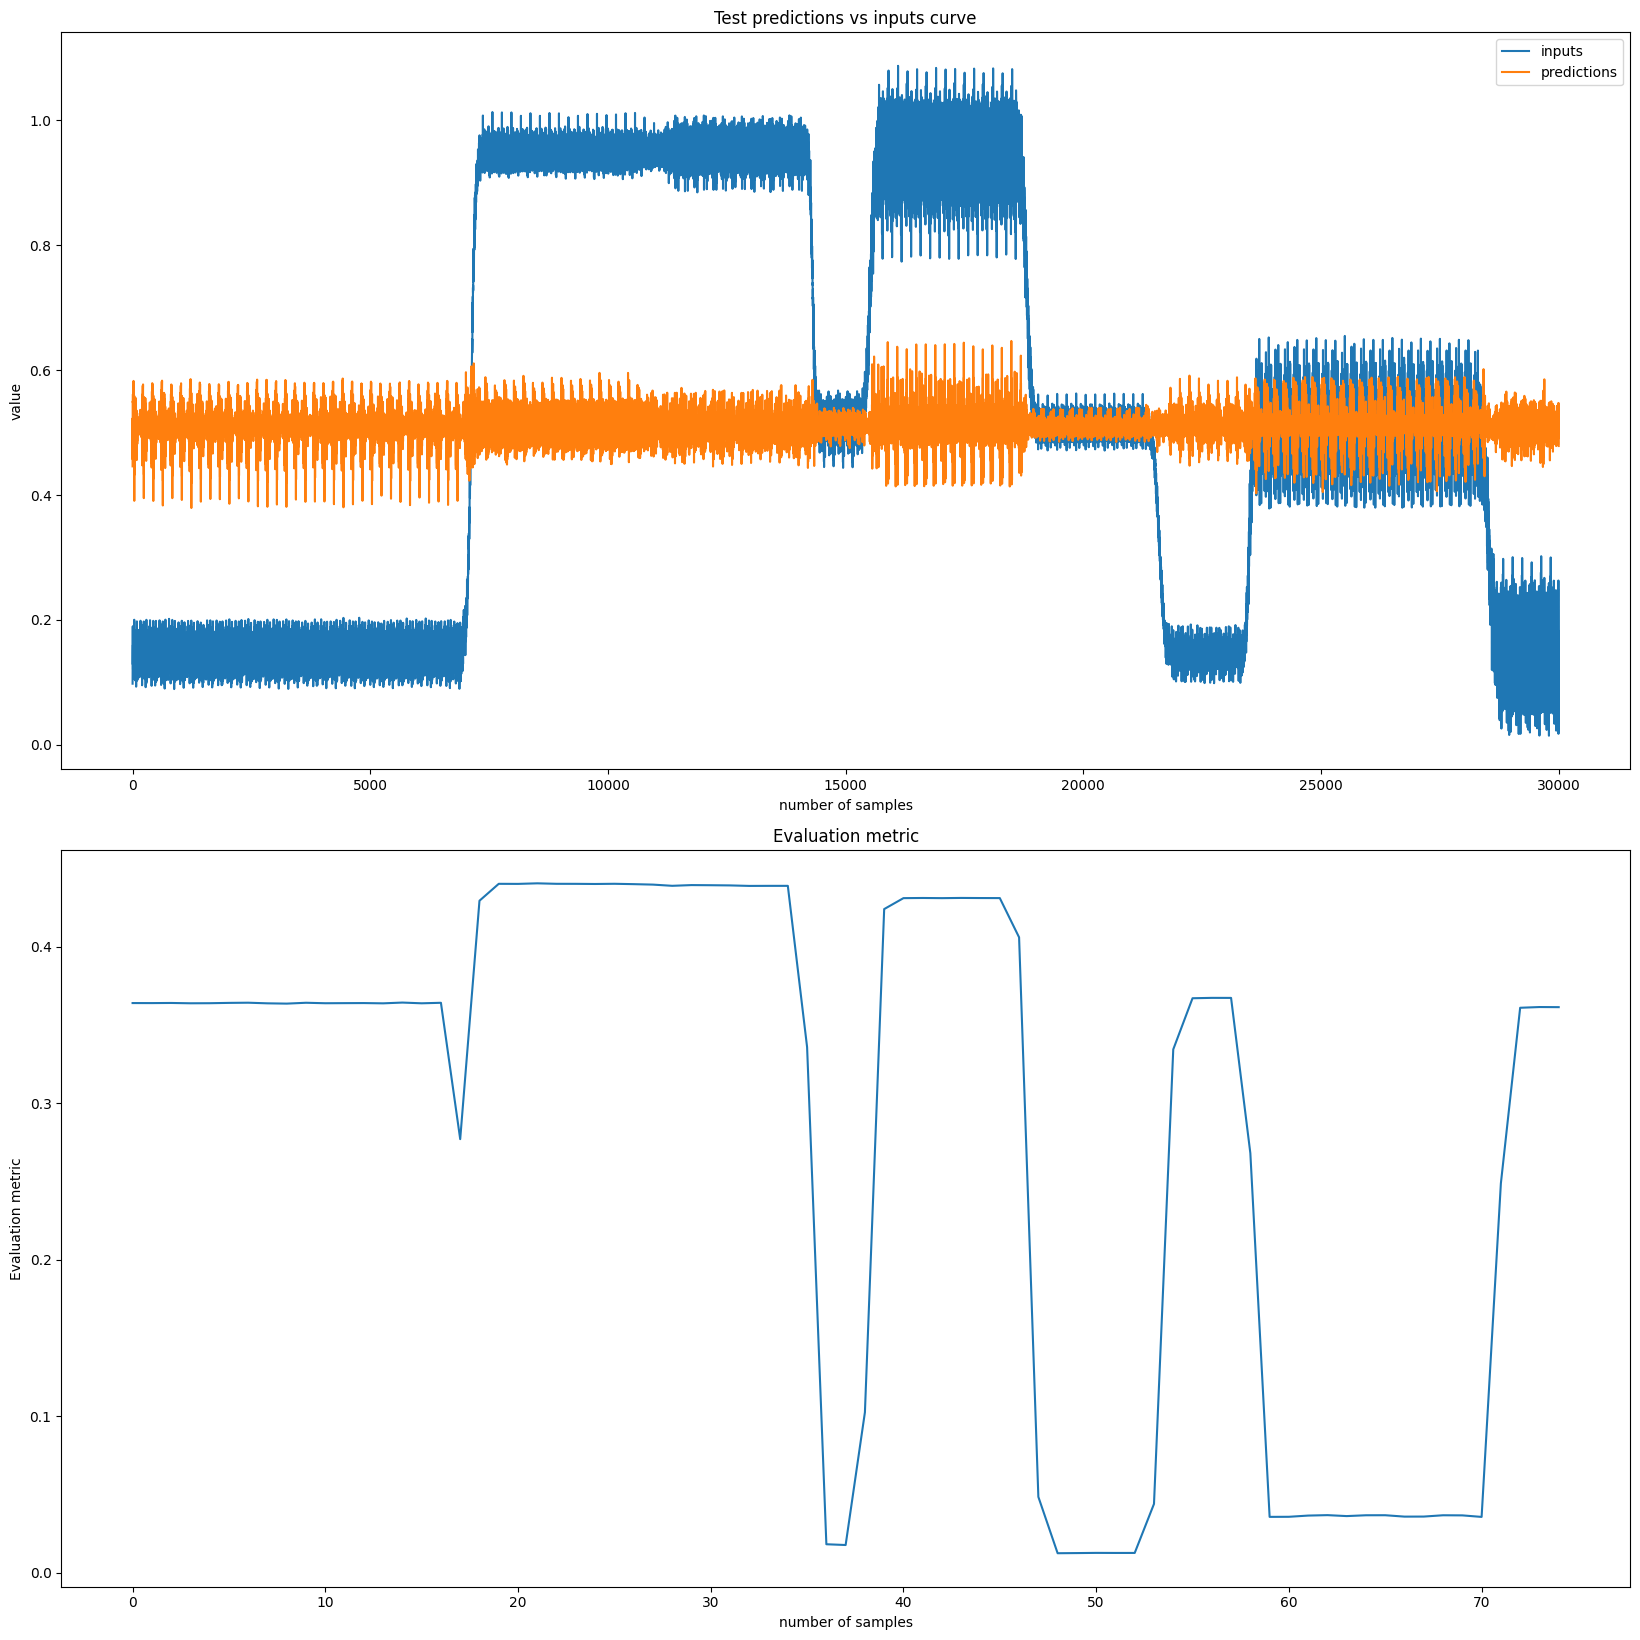

In [27]:

dataloader_drift = create_data_drift(seq_len, train_params["batch_size"])
predictions_drift, losses_drift, eval_metric_drift, true_values_drift = predict(autoencoder, dataloader_drift)
autoencoder_graph(predictions_drift, true_values_drift, eval_metric_drift)

## Drift detection
Adapt the predict function and autoencoder graph function so that depending on the difference between input and output drift is detected and this is shown in some way in a graph.

In [28]:
def predict_drift(model, dataset, treshold):
    drift = []
    predictions, true, losses, eval_metrics = [], [], [], []
    criterion = model.criterion
    model = model.eval()
    with torch.no_grad():
        for (seq_true,) in dataset:
            # seq_true = torch.Tensor(seq_true)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
                
            seq_true_prep = np.array([item for row in seq_true.tolist() for item in row])
            seq_pred_prep = np.array([item for row in seq_pred.tolist() for item in row])
            eval_metric = np.mean(np.abs(seq_true_prep - seq_pred_prep))

            # flatten all data to be able to use as an array
            predictions.append(seq_pred.numpy().flatten())
            true.append(seq_true.numpy().flatten())
            losses.append(loss.item())
            eval_metrics.append(eval_metric)
            if eval_metric > treshold:
                drift.append(True)
            else:
                drift.append(False)


    return predictions, losses, eval_metrics, true, drift

In [29]:
def autoencoder_graph_drift( predictions,inputs, eval_metric, drift):
    predictions = np.concatenate(predictions).tolist()
    inputs = np.concatenate(inputs).tolist()
    fig, axs = plt.subplots(3,1)

    axs[0].plot(inputs, label='inputs')
    axs[0].plot(predictions, label='predictions')
    axs[1].plot(eval_metric)
    axs[2].plot(drift)

    axs[0].set_xlabel("number of samples")
    axs[1].set_xlabel("number of samples")
    axs[2].set_xlabel("number of samples")

    axs[0].set_ylabel("pressure")
    axs[1].set_ylabel("evaluation metric")
    axs[2].set_ylabel("drift")

    axs[0].set_title("test predictions vs inputs curve")
    axs[1].set_title("evaluation metric")
    axs[2].set_title("drift detection")

    axs[0].legend()
    fig.set_size_inches(10, 16.5, forward=True)
    fig.tight_layout()
    fig.show()

C:\Users\laral\AppData\Local\Temp\ipykernel_38476\4225751139.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


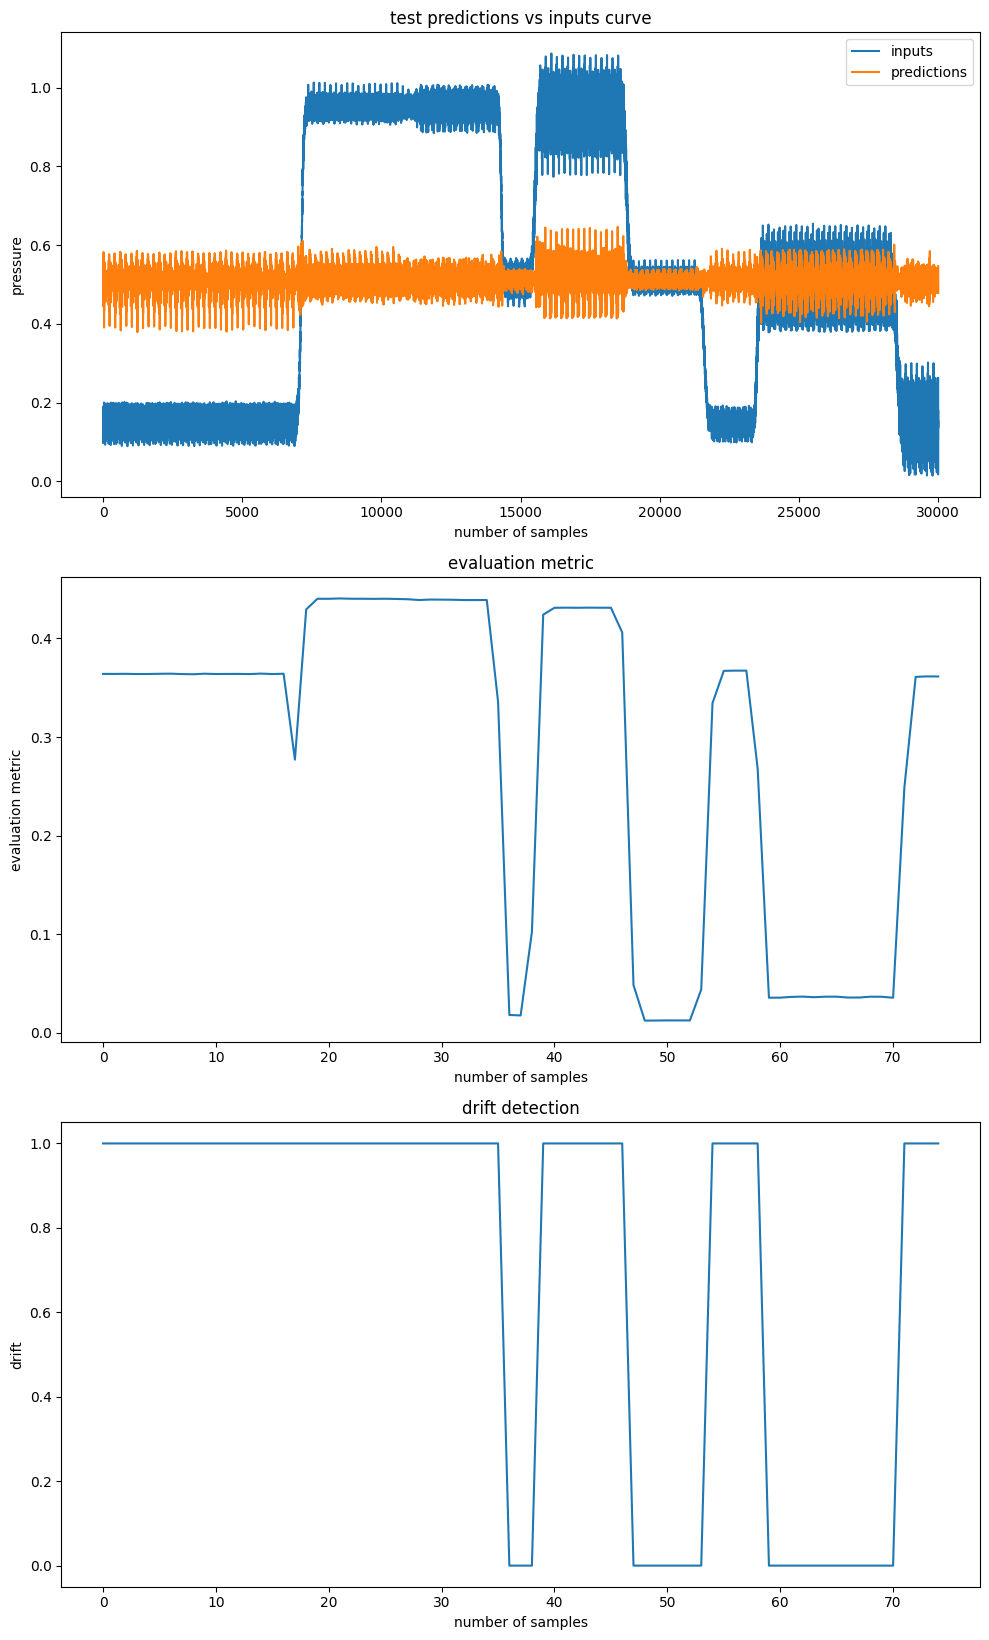

In [30]:
predictions_train, losses_train, eval_metric_drift, true_values_drift, drift = predict_drift(autoencoder, dataloader_drift, 0.2)
autoencoder_graph_drift(predictions_drift, true_values_drift, eval_metric_drift, drift)